# Assignment 10 - k means, Agglomerative and Density based spatial clustering on Donors choose dataset

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [0]:
!pip install chart_studio

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.downloader.download('vader_lexicon')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio.plotly as py

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## 1.1) Reading the data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
project_data = pd.read_csv('/content/gdrive/My Drive/donors choose/train_data.csv',nrows = 30000)
resource_data = pd.read_csv('/content/gdrive/My Drive/donors choose/resources.csv')

In [0]:
project_data.shape

(30000, 17)

In [0]:
project_data['project_is_approved'].value_counts()

1    25380
0     4620
Name: project_is_approved, dtype: int64

In [0]:
resource_data.shape

(1541272, 4)

In [0]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (30000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0  ... project_is_approved
473        100660  ...                   1
29891      146723  ...                   1

[2 rows x 17 columns]

In [0]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity   price
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1  149.00
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   14.95

## 1.2) preprocessing of project_subject_categories

In [0]:
print(project_data['project_subject_categories'].head(5))

473                      Applied Learning
29891    Math & Science, History & Civics
23374                 Literacy & Language
7176     Math & Science, Applied Learning
5145                  Literacy & Language
Name: project_subject_categories, dtype: object


In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
print(project_data['clean_categories'].head(5))

473                   AppliedLearning
29891     Math_Science History_Civics
23374               Literacy_Language
7176     Math_Science AppliedLearning
5145                Literacy_Language
Name: clean_categories, dtype: object


# 1.3) Preprocessing of project_subject_subcategories

In [0]:
print(project_data['project_subject_subcategories'].head(5))

473                        Early Development
29891           Mathematics, Social Sciences
23374                          ESL, Literacy
7176     Applied Sciences, Early Development
5145                                Literacy
Name: project_subject_subcategories, dtype: object


In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
print(project_data['clean_subcategories'].head(5))

473                      EarlyDevelopment
29891          Mathematics SocialSciences
23374                        ESL Literacy
7176     AppliedSciences EarlyDevelopment
5145                             Literacy
Name: clean_subcategories, dtype: object


## 1.4) Preprocessing of school_state

In [0]:
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())

state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv: kv[1]))

In [0]:
print(project_data['school_state'].head(5))

473      GA
29891    CA
23374    CA
7176     OH
5145     CA
Name: school_state, dtype: object


# 1.4) Preprocessing of project_grade_category

In [0]:
preproc = []
# tqdm is for printing the status bar
for sent in project_data['project_grade_category']:
    sent = sent.replace('Grades ', '')
    sent = sent.replace('PreK-2', 'PreKto2')
    sent = sent.replace('3-5', '3to5')
    sent = sent.replace('6-8', '6to8')
    sent = sent.replace('9-12', '9to12')
    preproc.append(sent)
project_data['project_grade_category']=preproc

In [0]:
print(project_data['project_grade_category'].head(5))

473      PreKto2
29891       3to5
23374    PreKto2
7176     PreKto2
5145        3to5
Name: project_grade_category, dtype: object


## 1.6) Preprocessing of teacher_prefix

In [0]:
print(type(project_data['teacher_prefix']))

<class 'pandas.core.series.Series'>


In [0]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].astype(str)
preproc = []
# tqdm is for printing the status bar
for sent in project_data['teacher_prefix']:
    sent = sent.replace('Mr.', 'Mr')
    sent = sent.replace('Mrs.', 'Mrs')
    sent = sent.replace('Dr.', 'Dr')
    sent = sent.replace('Ms.', 'Ms')
    sent = sent.replace('nan','Mr')
    preproc.append(sent)
project_data['teacher_prefix']=preproc

In [0]:
#['Teacher', 'Mrs.', 'Dr.', 'Mr.', 'Ms.']
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('')
my_counter = Counter()
for word in project_data['teacher_prefix'].values:
    my_counter.update(word.split())

teacher_dict = dict(my_counter)
sorted_teacher_dict = dict(sorted(teacher_dict.items(), key=lambda kv: kv[1]))

In [0]:
print(project_data['teacher_prefix'].value_counts())

Mrs        15682
Ms         10779
Mr          2896
Teacher      643
Name: teacher_prefix, dtype: int64


## 1.7) Preprocessing of Essays

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 30000/30000 [00:15<00:00, 1924.96it/s]


In [0]:
# after preprocesing
preprocessed_essays[2000]

'teacher high poverty school district texas panhandle students faced several challenges classroom school population 90 hispanic 75 students qualify free reduced lunches many students school stable part life teacher want classroom best home students one want home comfortable welcoming everyone enters doors want students walk everyday feel like home students intelligent hard working boys girls love learn one thing push students year make aware much potential succeed remember sitting elementary school uncomfortable seats itching stand stretch remember wishing teacher would let stretch assignments allow us choose would sit horrible thought needed straight rows order maximize learning teacher use nowadays starting realize students need comfortable help maximize learning traditional assigned desks faced rows new flexible seating classroom instead assigning places sit allowing students choose seats day requested flexible seating used classroom already using flexible seating room allows studen

In [0]:
project_data['essay']=preprocessed_essays

## 1.8) Preprocessing of project_titles

In [0]:
# similarly you can preprocess the titles also
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 30000/30000 [00:00<00:00, 40786.79it/s]


In [0]:
project_data['project_title']=preprocessed_titles

In [0]:
preprocessed_titles[10]

'story book wonder'

## 1.9) Preparing for data model

In [0]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

school_state : categorical data,
clean_categories : categorical data,
clean_subcategories : categorical data,
project_grade_category : categorical data,
teacher_prefix : categorical data,
project_title : text data,
text : text data,
project_resource_summary: text data (optinal),
quantity : numerical (optinal),
teacher_number_of_previously_posted_projects : numerical,
price : numerical,

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open (r'/content/gdrive/My Drive/donors choose/glove_vectors', "rb") as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

## Clustering

## 2.1) Splitting the data into train and test(or CV)

In [0]:
#Train Test Split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(project_data,project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
# X_cv.drop(['project_is_approved'], axis=1, inplace=True)
print(X_train.shape)
print(X_test.shape)

(20100, 17)
(9900, 17)


### Vectorizing the categorical features

In [0]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cat = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_cat.fit(X_train['clean_categories'].values)
print(vectorizer_cat.get_feature_names())


categories_one_hot_train = vectorizer_cat.transform(X_train['clean_categories'].values)
# categories_one_hot_cv = vectorizer_cat.transform(X_cv['clean_categories'].values)
categories_one_hot_test = vectorizer_cat.transform(X_test['clean_categories'].values)
print("Shape of matrix after one hot encodig_train ",categories_one_hot_train.shape)
# print("Shape of matrix after one hot encodig_cv ",categories_one_hot_cv.shape)
print("Shape of matrix after one hot encodig_test ",categories_one_hot_test.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig_train  (20100, 9)
Shape of matrix after one hot encodig_test  (9900, 9)


In [0]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer_sub_cat = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_cat.fit(X_train['clean_subcategories'].values)
print(vectorizer_sub_cat.get_feature_names())


sub_categories_one_hot_train = vectorizer_sub_cat.transform(X_train['clean_subcategories'].values)
# sub_categories_one_hot_cv = vectorizer_sub_cat.transform(X_cv['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer_sub_cat.transform(X_test['clean_subcategories'].values)
print("Shape of matrix after one hot encodig_train ",sub_categories_one_hot_train.shape)
# print("Shape of matrix after one hot encodig_cv ",sub_categories_one_hot_cv.shape)
print("Shape of matrix after one hot encodig_test ",sub_categories_one_hot_test.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig_train  (20100, 30)
Shape of matrix after one hot encodig_test  (9900, 30)


In [0]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_state = CountVectorizer( lowercase=False, binary=True)
vectorizer_state.fit(X_train['school_state'].values)
print(vectorizer_state.get_feature_names())


school_state_one_hot_train = vectorizer_state.transform(X_train['school_state'].values)
# school_state_one_hot_cv = vectorizer_state.transform(X_cv['school_state'].values)
school_state_one_hot_test = vectorizer_state.transform(X_test['school_state'].values)
print("Shape of matrix after one hot encodig_train ",school_state_one_hot_train.shape)
# print("Shape of matrix after one hot encodig_cv ",school_state_one_hot_cv.shape)
print("Shape of matrix after one hot encodig_test ",school_state_one_hot_test.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encodig_train  (20100, 51)
Shape of matrix after one hot encodig_test  (9900, 51)


In [0]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_teacherprefix = CountVectorizer( lowercase=False, binary=True)
vectorizer_teacherprefix.fit(X_train['teacher_prefix'].values.astype('U'))
print(vectorizer_teacherprefix.get_feature_names())

#https://stackoverflow.com/a/39308809/8089731
teacher_prefix_one_hot_train = vectorizer_teacherprefix.transform(X_train['teacher_prefix'].values.astype('U'))
# teacher_prefix_one_hot_cv = vectorizer_teacherprefix.transform(X_cv['teacher_prefix'].values.astype('U'))
teacher_prefix_one_hot_test = vectorizer_teacherprefix.transform(X_test['teacher_prefix'].values.astype('U'))
print("Shape of matrix after one hot encodig_train ",teacher_prefix_one_hot_train.shape)
# print("Shape of matrix after one hot encodig_cv ",teacher_prefix_one_hot_cv.shape)
print("Shape of matrix after one hot encodig_test ",teacher_prefix_one_hot_test[:5,:])

['Mr', 'Mrs', 'Ms', 'Teacher']
Shape of matrix after one hot encodig_train  (20100, 4)
Shape of matrix after one hot encodig_test    (0, 1)	1
  (1, 2)	1
  (2, 1)	1
  (3, 1)	1
  (4, 2)	1


In [0]:
print(project_data['project_grade_category'].unique())# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
# https://stackoverflow.com/a/38161028/8089731
pattern = "(?u)\\b[\\w-]+\\b"
vectorizer_projectgrade = CountVectorizer(token_pattern=pattern, lowercase=False, binary=True)
vectorizer_projectgrade.fit(X_train['project_grade_category'].values)
print(vectorizer_projectgrade.get_feature_names())

#https://stackoverflow.com/a/39308809/8089731
project_grade_category_one_hot_train = vectorizer_projectgrade.transform(X_train['project_grade_category'].values)
# project_grade_category_one_hot_cv = vectorizer_projectgrade.transform(X_cv['clean_project_grade_category'].values)
project_grade_category_one_hot_test = vectorizer_projectgrade.transform(X_test['project_grade_category'].values)
print("Shape of matrix after one hot encodig_train ",project_grade_category_one_hot_train.shape)
# print("Shape of matrix after one hot encodig_cv ",project_grade_category_one_hot_cv.shape)
print("Shape of matrix after one hot encodig_test ",project_grade_category_one_hot_test[:5,:])

['PreKto2' '3to5' '6to8' '9to12']
['3to5', '6to8', '9to12', 'PreKto2']
Shape of matrix after one hot encodig_train  (20100, 4)
Shape of matrix after one hot encodig_test    (0, 3)	1
  (1, 3)	1
  (2, 0)	1
  (3, 1)	1
  (4, 1)	1


### Vectorizing the numerical features


In [0]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
print(price_data.head())
#print(project_data.columns)
print(X_train.columns)

        id    price  quantity
0  p000001   459.56         7
1  p000002   515.89        21
2  p000003   298.97         4
3  p000004  1113.69        98
4  p000005   485.99         8
Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay'],
      dtype='object')


In [0]:
# join two dataframes in python: 
X_train = pd.merge(X_train, price_data, on = "id", how = "left")
X_test = pd.merge(X_test, price_data, on = "id", how = "left")

In [0]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

# price_scalar = StandardScaler()
# price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
# print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
# Now standardize the data with above maen and variance.
price_standardized_train = normalize(X_train['price'].values.reshape(-1, 1),axis=0)
# price_standardized_cv = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
price_standardized_test = normalize(X_test['price'].values.reshape(-1, 1),axis=0)
print(price_standardized_train.shape)
# print(price_standardized_cv.shape)
print(price_standardized_test.shape)

(20100, 1)
(9900, 1)


In [0]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

# quantity_scalar = StandardScaler()
# quantity_scalar.fit(X_train['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
# print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
quantity_standardized_train = normalize(X_train['quantity'].values.reshape(-1, 1),axis=0)
# quantity_standardized_cv = quantity_scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
quantity_standardized_test = normalize(X_test['quantity'].values.reshape(-1, 1),axis=0)
print(quantity_standardized_train.shape)
# print(quantity_standardized_cv.shape)
print(quantity_standardized_test.shape)

(20100, 1)
(9900, 1)


In [0]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

# teacher_number_of_previously_posted_projects_scalar = StandardScaler()
# teacher_number_of_previously_posted_projects_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
# print(f"Mean : {teacher_number_of_previously_posted_projects_scalar.mean_[0]}, Standard deviation : {np.sqrt(teacher_number_of_previously_posted_projects_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
teacher_number_of_previously_posted_projects_standardized_train = normalize(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1),axis=0)
# teacher_number_of_previously_posted_projects_standardized_cv = teacher_number_of_previously_posted_projects_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
teacher_number_of_previously_posted_projects_standardized_test = normalize(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1),axis=0)
print(teacher_number_of_previously_posted_projects_standardized_train.shape)
# print(teacher_number_of_previously_posted_projects_standardized_cv.shape)
print(teacher_number_of_previously_posted_projects_standardized_test.shape)

(20100, 1)
(9900, 1)


## 2.2) Make data model ready: encoding essay and project title

In [0]:
X_train.head(2)

Unnamed: 0       id  ...  price quantity
0      119025  p090286  ...  179.0        3
1       82934  p053561  ...  379.0        1

[2 rows x 19 columns]

## TFIDF Vectorizer on project_text/essay(Train,Cv,Test)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essays = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1,2))
vectorizer_tfidf_essays.fit(X_train['essay'])

text_tfidf_train = vectorizer_tfidf_essays.transform(X_train['essay'])
# text_tfidf_cv = vectorizer_tfidf_essays.transform(X_cv['preprocessed_essays'])
text_tfidf_test = vectorizer_tfidf_essays.transform(X_test['essay'])
print("Shape of matrix after tfidf_text_train ",text_tfidf_train.shape)
# print("Shape of matrix after tfidf_text_cv ",text_tfidf_cv.shape)
print("Shape of matrix after tfidf_text_test ",text_tfidf_test.shape)

Shape of matrix after tfidf_text_train  (20100, 5000)
Shape of matrix after tfidf_text_test  (9900, 5000)


### TFIDF Vectorizer on project_titles(Train,Cv,Test)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_title = TfidfVectorizer(min_df=10, max_features=5000,ngram_range=(1,2))
vectorizer_tfidf_title.fit(X_train['project_title'])

title_tfidf_train = vectorizer_tfidf_title.transform(X_train['project_title'])
# title_tfidf_cv = vectorizer_tfidf_title.transform(X_cv['preprocessed_titles'])
title_tfidf_test = vectorizer_tfidf_title.transform(X_test['project_title'])
print("Shape of matrix after tfidf_title_train ",title_tfidf_train.shape)
# print("Shape of matrix after tfidf_title_cv ",title_tfidf_cv.shape)
print("Shape of matrix after tfidf_title_test ",title_tfidf_test.shape)

Shape of matrix after tfidf_title_train  (20100, 1677)
Shape of matrix after tfidf_title_test  (9900, 1677)


In [0]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price_x',
       'quantity_x', 'price_y', 'quantity_y', 'price', 'quantity'],
      dtype='object')

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((categories_one_hot_train,sub_categories_one_hot_train,school_state_one_hot_train,teacher_prefix_one_hot_train
               ,project_grade_category_one_hot_train,price_standardized_train,quantity_standardized_train
               ,teacher_number_of_previously_posted_projects_standardized_train,text_tfidf_train,title_tfidf_train))
# X_cr = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,school_state_one_hot_cv,teacher_prefix_one_hot_cv
#                ,project_grade_category_one_hot_cv,price_standardized_cv,quantity_standardized_cv
#                ,teacher_number_of_previously_posted_projects_standardized_cv,text_tfidf_cv,title_tfidf_cv)).tocsr()
X_te = hstack((categories_one_hot_test,sub_categories_one_hot_test,school_state_one_hot_test,teacher_prefix_one_hot_test
               ,project_grade_category_one_hot_test,price_standardized_test,quantity_standardized_test
               ,teacher_number_of_previously_posted_projects_standardized_test,text_tfidf_test,title_tfidf_test))

print("Final Data matrix on TFIDF")
print(X_tr.shape, y_train.shape)
# print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)


Final Data matrix on TFIDF
(20100, 6778) (20100,)
(9900, 6778) (9900,)


In [0]:
X_te.shape

(9900, 6778)

## A) Dimensionality reduction on the selected features

In [0]:
# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()
# X_tr = scaler.fit_transform(X_tr,y_train)
# X_te = scaler.transform(X_te)
###########################################################################
from sklearn.feature_selection import SelectKBest, chi2
t = SelectKBest(chi2,k=5000).fit(X_tr, y_train)
X_tr = t.transform(X_tr)
X_te = t.transform(X_te)
###########################################################################
print("Final Data matrix on TFIDF")
print(X_tr.shape, y_train.shape)
# print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix on TFIDF
(20100, 5000) (20100,)
(9900, 5000) (9900,)


## 1) Applying K means clustering

100%|██████████| 5/5 [17:14<00:00, 217.36s/it]


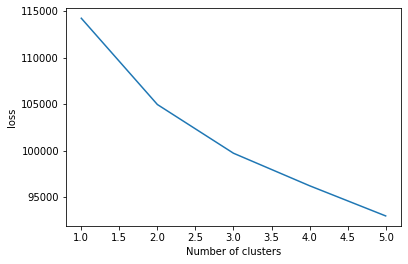

CPU times: user 17min 22s, sys: 45.7 s, total: 18min 7s
Wall time: 17min 14s


In [0]:
%%time
from sklearn.cluster import KMeans

loss = []
for k in tqdm(range(1,6)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_tr)
    loss.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1,6),loss)
plt.xlabel("Number of clusters")
plt.ylabel("loss")
plt.show()

In [0]:
best_k=3

In [0]:
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(X_tr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
essays = X_train['essay'].values

cluster1 = []
cluster2 = []
cluster3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(essays[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(essays[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(essays[i])

In [0]:
for i in range(3):
    print('%s\n'%(cluster1[i]))

school located downtown winston salem north carolina edge known arts district fitting considering charter school focuses teaching arts classroom enhance learning drama dance music visual arts right learning loving find printed 4th grade shirts not statement description students feel learning also reflective smiles student face enter classroom every day teach twenty 4th graders eager see day bring enjoy school make connections subjects learning community learners doers benefits technology classroom take many forms also used promote literacy students children move school gaps student achievement increase possible beginning readers fluent readers one classroom students want read books peers reading no matter ability differences among children students given chance listen complex text read comprehension could increase audio books used tandem direct small group instruction provide struggling readers rich vocabulary concepts student could not read comprehend technology intend provide high in

In [0]:
for i in range(3):
    print('%s\n'%(cluster2[i]))

students special group 6th 7th 8th graders classification mildly intellectually disabled characteristics autism work hard always willing learn new things part class mission statement learn skills students take care independent possible adults one way work towards goal cook week ultimately hope able give small group students simple recipe boxed mix complete without help adults working together using skills learned small refrigerator classroom allow us properly refrigerate ingredients milk eggs produce need kept cold without bring ice chests home also able keep items hand limited time may eliminate need shop time needed recipe also able safely keep leftovers end school day cooking skill benefit students lifetime cooking also learn things following steps sequence estimating costs making grocery list fractions measurement making healthy choices small refrigerator would help make realistic positive learning experience nannan

students 5th graders hail working class immigrant neighborhood la

In [0]:
for i in range(3):
    print('%s\n'%(cluster3[i]))

students entirety school serve students school discipline science students come ready learn explore experiment become critical thinkers part school title 1 means come high poverty may not access materials resources home part school magnet means parents may not live close chosen send child opportunities experiences part school moment students tile floor sit not individual stations carpet would give defined space would help focusing concept hand support goal using proper behavior carpet would also inviting space scholars read science concepts share informal way peers end class carpet perfect place scholars gather share learned time science lab hear ideas classmates nannan

group life skills students amazing wills succeed despite individual challenges come together help times struggle confusion need may fail times everyday show give everything every day students come school work extremely hard successful spite disabilities impairments never give lose faith strive great every day funding p

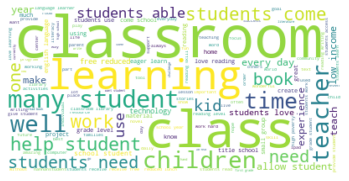

In [0]:
#cluster 1
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

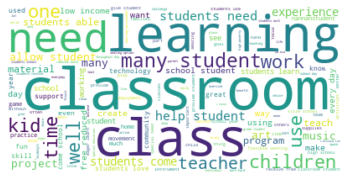

In [0]:
#cluster 2
words=''
for i in cluster2:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

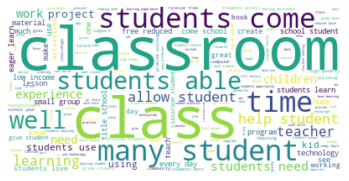

In [0]:
#cluster 3
words=''
for i in cluster3:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2) Agglomerative clustering

In [0]:
from scipy.sparse import hstack
X_tr = hstack((categories_one_hot_train,sub_categories_one_hot_train,school_state_one_hot_train,teacher_prefix_one_hot_train
               ,project_grade_category_one_hot_train,price_standardized_train,quantity_standardized_train
               ,teacher_number_of_previously_posted_projects_standardized_train,text_tfidf_train,title_tfidf_train))
# X_cr = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,school_state_one_hot_cv,teacher_prefix_one_hot_cv
#                ,project_grade_category_one_hot_cv,price_standardized_cv,quantity_standardized_cv
#                ,teacher_number_of_previously_posted_projects_standardized_cv,text_tfidf_cv,title_tfidf_cv)).tocsr()
X_te = hstack((categories_one_hot_test,sub_categories_one_hot_test,school_state_one_hot_test,teacher_prefix_one_hot_test
               ,project_grade_category_one_hot_test,price_standardized_test,quantity_standardized_test
               ,teacher_number_of_previously_posted_projects_standardized_test,text_tfidf_test,title_tfidf_test))

print("Final Data matrix on TFIDF")
print(X_tr.shape, y_train.shape)
# print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix on TFIDF
(20100, 6778) (20100,)
(9900, 6778) (9900,)


In [0]:
X_te.shape

(9900, 6778)

## A) Dimensionality Reduction on the selected features

In [0]:
# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()
# X_tr = scaler.fit_transform(X_tr,y_train)
# X_te = scaler.transform(X_te)
###########################################################################
from sklearn.feature_selection import SelectKBest, chi2
t = SelectKBest(chi2,k=5000).fit(X_tr, y_train)
X_tr = t.transform(X_tr)
X_te = t.transform(X_te)
###########################################################################
print("Final Data matrix on TFIDF")
print(X_tr.shape, y_train.shape)
# print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix on TFIDF
(20100, 5000) (20100,)
(9900, 5000) (9900,)


In [0]:
X_tr = X_tr[:5000]
X_train = X_train[:5000]

In [0]:
X_tr.shape

(5000, 5000)

### for k = 2

In [0]:
from sklearn.cluster import AgglomerativeClustering

aggcl=AgglomerativeClustering(n_clusters=2).fit(X_tr.toarray())

In [0]:
cluster1=[]
cluster2=[]
essays = X_train['essay'].values
for i in range(aggcl.labels_.shape[0]):
    if aggcl.labels_[i] == 0:
        cluster1.append(essays[i])
    elif aggcl.labels_[i] == 1:
        cluster2.append(essays[i])

In [0]:
for i in range(3):
    print('%s\n'%(cluster1[i]))

school located downtown winston salem north carolina edge known arts district fitting considering charter school focuses teaching arts classroom enhance learning drama dance music visual arts right learning loving find printed 4th grade shirts not statement description students feel learning also reflective smiles student face enter classroom every day teach twenty 4th graders eager see day bring enjoy school make connections subjects learning community learners doers benefits technology classroom take many forms also used promote literacy students children move school gaps student achievement increase possible beginning readers fluent readers one classroom students want read books peers reading no matter ability differences among children students given chance listen complex text read comprehension could increase audio books used tandem direct small group instruction provide struggling readers rich vocabulary concepts student could not read comprehend technology intend provide high in

In [0]:
for i in range(3):
    print('%s\n'%(cluster2[i]))

students entirety school serve students school discipline science students come ready learn explore experiment become critical thinkers part school title 1 means come high poverty may not access materials resources home part school magnet means parents may not live close chosen send child opportunities experiences part school moment students tile floor sit not individual stations carpet would give defined space would help focusing concept hand support goal using proper behavior carpet would also inviting space scholars read science concepts share informal way peers end class carpet perfect place scholars gather share learned time science lab hear ideas classmates nannan

school title school trying provide always changing resources needed coordinate current educational standards also change often upcoming school year fortunate enough teaching great group sixth graders group students comes small rural school houses approximately three hundred kindergarten sixth graders students come low 

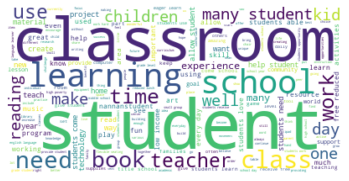

In [0]:
#cluster 1
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

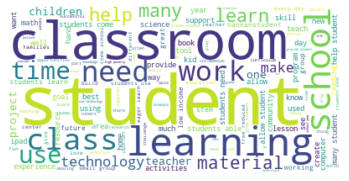

In [0]:
#cluster 2
words=''
for i in cluster2:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3) DBSCAN (Density based spatial clustering)*italicized text*

In [0]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price_x',
       'quantity_x', 'price_y', 'quantity_y', 'price', 'quantity'],
      dtype='object')

In [0]:
from scipy.sparse import hstack
X_tr = hstack((categories_one_hot_train,sub_categories_one_hot_train,school_state_one_hot_train,teacher_prefix_one_hot_train
               ,project_grade_category_one_hot_train,price_standardized_train,quantity_standardized_train
               ,teacher_number_of_previously_posted_projects_standardized_train,text_tfidf_train,title_tfidf_train))
# X_cr = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,school_state_one_hot_cv,teacher_prefix_one_hot_cv
#                ,project_grade_category_one_hot_cv,price_standardized_cv,quantity_standardized_cv
#                ,teacher_number_of_previously_posted_projects_standardized_cv,text_tfidf_cv,title_tfidf_cv)).tocsr()
X_te = hstack((categories_one_hot_test,sub_categories_one_hot_test,school_state_one_hot_test,teacher_prefix_one_hot_test
               ,project_grade_category_one_hot_test,price_standardized_test,quantity_standardized_test
               ,teacher_number_of_previously_posted_projects_standardized_test,text_tfidf_test,title_tfidf_test))

print("Final Data matrix on TFIDF")
print(X_tr.shape, y_train.shape)
# print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix on TFIDF
(20100, 6778) (20100,)
(9900, 6778) (9900,)


In [0]:
X_te.shape

(9900, 6778)

## A) Dimensionality reduction on the selected features

In [0]:
# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()
# X_tr = scaler.fit_transform(X_tr,y_train)
# X_te = scaler.transform(X_te)
###########################################################################
from sklearn.feature_selection import SelectKBest, chi2
t = SelectKBest(chi2,k=5000).fit(X_tr, y_train)
X_tr = t.transform(X_tr)
X_te = t.transform(X_te)
###########################################################################
print("Final Data matrix on TFIDF")
print(X_tr.shape, y_train.shape)
# print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix on TFIDF
(20100, 5000) (20100,)
(9900, 5000) (9900,)


In [0]:
X_tr = X_tr[:5000]
X_train = X_train[:5000]

In [0]:
X_tr.shape

(5000, 5000)

In [0]:
from sklearn.preprocessing import StandardScaler
# abc=StandardScaler().fit_transform(X_tr.toarray())
abc=X_tr.toarray()
abc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(abc, abc[1].reshape(1, -1))

array([[3.1980902 ],
       [0.        ],
       [3.4900221 ],
       ...,
       [3.63280176],
       [2.84449477],
       [3.15049923]])

5000it [12:54,  6.41it/s]


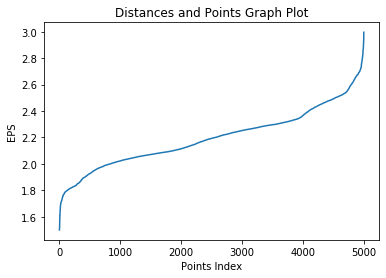

CPU times: user 12min 50s, sys: 3.78 s, total: 12min 53s
Wall time: 12min 54s


In [0]:
%%time
#https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan
#https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r
#Some references from where help was taken
min_pts=10
kth_dist=[]
dist = []
for row in tqdm(X_tr):
    row_dist = np.sort(np.sum((X_tr.toarray()-row.toarray())**2,axis=1),axis=None)
    dist.append(row_dist[min_pts])
kth_dist=np.sort(np.sqrt(np.array(dist)))
points = [x for x in range(X_tr.shape[0])]
plt.plot(points, kth_dist)
plt.xlabel('Points Index')
plt.ylabel('EPS')
plt.title('Distances and Points Graph Plot')
plt.show()


In [0]:
best_eps=2.70

In [0]:
from sklearn.cluster import DBSCAN
eps=best_eps
model = DBSCAN(eps=eps,min_samples=10)
model.fit(X_tr)

DBSCAN(algorithm='auto', eps=2.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [0]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2.7,n_jobs=-1)
dbscan.fit(abc)
print('No of clusters: ',len(set(dbscan.labels_)))
print('Cluster are including noise i.e -1: ',set(dbscan.labels_))

No of clusters:  2
Cluster are including noise i.e -1:  {0, -1}


In [0]:
#ignoring -1 as it is for noise
cluster1=[]
noisecluster1=[]
for i in range(dbscan.labels_.shape[0]):
    if dbscan.labels_[i] == 0:
        cluster1.append(essays[i])
    elif dbscan.labels_[i] == -1:
        noisecluster1.append(essays[i])

In [0]:
for i in range(3):
    print('%s\n'%(cluster1[i]))

school located downtown winston salem north carolina edge known arts district fitting considering charter school focuses teaching arts classroom enhance learning drama dance music visual arts right learning loving find printed 4th grade shirts not statement description students feel learning also reflective smiles student face enter classroom every day teach twenty 4th graders eager see day bring enjoy school make connections subjects learning community learners doers benefits technology classroom take many forms also used promote literacy students children move school gaps student achievement increase possible beginning readers fluent readers one classroom students want read books peers reading no matter ability differences among children students given chance listen complex text read comprehension could increase audio books used tandem direct small group instruction provide struggling readers rich vocabulary concepts student could not read comprehend technology intend provide high in

In [0]:
for i in range(3):
    print('%s\n'%(noisecluster1[i]))

classroom one students learn important content principles also ways methods better people productive members society love teaching subject students going use every day students get excited class pay attention know materials going benefit rest life teaching drivers ed scary times great times fun classroom also rewarding car student learning important principles handle rules road purpose dash cam enhance learning students camera record driving sessions students already class dash cam allow instructor go back watch mistakes good things students done car turn translate back classroom portion better teacher preparing students not make mistakes others made review sessions make improvements next time nannan

every monday afternoon 3 4pm madison school garden club meets students led student centered activities enable understand learn care plant beds learn seed becomes fruit vegetable grow herbs plant flowers even compost nine teachers seventy five students grades kindergarten sixth grade apart

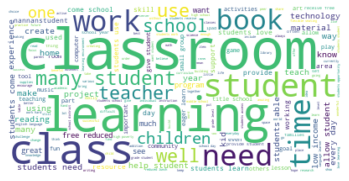

In [0]:
#cluster 1
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

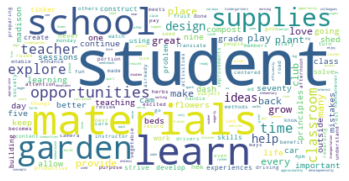

In [0]:
#noise cluster 1
words=''
for i in noisecluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3) Conclusion

In [0]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best k"]
x.add_row(['TFIDF', 'k means', '3'])
x.add_row(['TFIDF', 'Agglomerative clustering', '2'])
print (x)

+------------+--------------------------+--------+
| Vectorizer |          Model           | Best k |
+------------+--------------------------+--------+
|   TFIDF    |         k means          |   3    |
|   TFIDF    | Agglomerative clustering |   2    |
+------------+--------------------------+--------+


In [0]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Best k","Eps","Number of clusters(INCLUDING NOISE)"]
x.add_row(['TFIDF','2',2.7,2])
print(x)

+------------+--------+-----+-------------------------------------+
| Vectorizer | Best k | Eps | Number of clusters(INCLUDING NOISE) |
+------------+--------+-----+-------------------------------------+
|   TFIDF    |   2    | 2.7 |                  2                  |
+------------+--------+-----+-------------------------------------+
